In [27]:
import os
import random
import matplotlib.pyplot as plt
from torchvision.io import read_image

import torch
import torchvision
import torchsummary
import torchmetrics


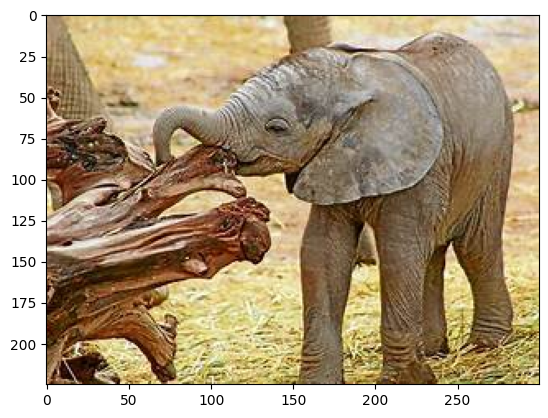

In [35]:
# Ruta de la carpeta del conjunto de datos de prueba
test_dataset_folder = "./test_dataset"

# Obtener una subcarpeta aleatoria del conjunto de datos de prueba
subfolder = random.choice(os.listdir(test_dataset_folder))
subfolder_path = os.path.join(test_dataset_folder, subfolder)

# Obtener una imagen aleatoria de la subcarpeta
random_image_filename = random.choice(os.listdir(subfolder_path))
random_image_path = os.path.join(subfolder_path, random_image_filename)

# Leer la imagen y mostrarla
random_image = read_image(random_image_path)
plt.imshow(random_image.permute(1, 2, 0)) 
plt.show()


In [36]:
CANTIDAD_CLASES = 10
ANCHO_IMAGENES = 150
ALTO_IMAGENES = 150

In [37]:
class ConvModel(torch.nn.Module):
    def __init__(self, output_units):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding='same')
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same')
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(in_features=10368, out_features=512)
        self.fc2 = torch.nn.Linear(in_features=512, out_features=output_units)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.pool4(torch.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

conv_model = ConvModel(CANTIDAD_CLASES)

# Si hay una GPU disponible muevo el modelo allí para aprovechar ese recurso
if torch.cuda.is_available():
    conv_model.to("cuda")

torchsummary.summary(conv_model, (3, ANCHO_IMAGENES, ALTO_IMAGENES))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 150, 150]             448
         MaxPool2d-2           [-1, 16, 75, 75]               0
            Conv2d-3           [-1, 32, 75, 75]           4,640
         MaxPool2d-4           [-1, 32, 37, 37]               0
            Conv2d-5           [-1, 64, 37, 37]          18,496
         MaxPool2d-6           [-1, 64, 18, 18]               0
            Conv2d-7          [-1, 128, 18, 18]          73,856
         MaxPool2d-8            [-1, 128, 9, 9]               0
            Linear-9                  [-1, 512]       5,308,928
           Linear-10                   [-1, 10]           5,130
Total params: 5,411,498
Trainable params: 5,411,498
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.26
Forward/backward pass size (MB): 6.37
Params size (MB): 20.64
Estima

In [38]:
modelo_ruta = "./model/naug_conv_model.pt"

modelo_cargado = torch.load(modelo_ruta)

modelo_cargado.eval()

ConvModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [43]:
import torchvision.transforms as transforms
from PIL import Image

# Función para leer y preprocesar una imagen
def read_image(image_path):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((ANCHO_IMAGENES, ALTO_IMAGENES)),
        transforms.ToTensor(),
    ])
    image = preprocess(image)
    image.unsqueeze_(0)  # Agregar una dimensión de lote
    return image

In [44]:
random_image = read_image(random_image_path)

In [45]:
# Pasar la imagen a través del modelo
with torch.no_grad():
    outputs = modelo_cargado(random_image)

In [50]:
import torch.nn.functional as F
from translate import get_class_name

# Obtener las probabilidades de clase y la clase predicha
probabilities = F.softmax(outputs, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

class_name = get_class_name(predicted_class)

# Mostrar la imagen y la clase predicha
plt.imshow(random_image.cpu().squeeze().permute(1, 2, 0))
plt.title(f"Predicted Class: {class_name}")
plt.axis('off')
plt.show()

ImportError: cannot import name 'get_class_name' from 'translate' (c:\Users\cbureu\Documents\Repo\CEIA\VCII\translate.py)